<a href="https://colab.research.google.com/github/anjanasa13/Traffic-Pattern-Prediction_GRU/blob/main/Predicting_traffic_patterns_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Traffic congestion is a pervasive issue in urban areas, often exacerbated by the steady rise in urban populations. With outdated infrastructure struggling to accommodate the influx of residents seeking opportunities, traffic jams become a frequent occurrence.

The consequences of traffic congestion are far-reaching. Increased fuel combustion leads to heightened carbon emissions, worsening air pollution. Additionally, traffic congestion incurs significant time and monetary costs.

In this project, the focus will be on delving into the dataset of four junctions to develop a model capable of predicting traffic patterns. Such a model holds promise for alleviating traffic congestion by providing insights into traffic behavior, aiding in the development of infrastructure solutions to mitigate this pervasive issue.

In [2]:
# Importing necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import files
uploaded = files.upload()

Saving traffic.csv to traffic.csv


In [4]:
data=pd.read_csv("/content/traffic.csv")

In [5]:
data.head(5)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


Regarding the data:

The dataset comprises counts of vehicles recorded at four junctions on an hourly basis. The CSV file includes the following features:

1. DateTime
2. Junctions
3. Vehicles
4. ID

Data collection from the sensors at each junction occurred at various times, resulting in traffic data spanning different time periods. Additionally, it's worth noting that certain junctions may exhibit limited or sparse data availability.

In [6]:
data.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [7]:


# Convert "DateTime" column to datetime format
data["DateTime"] = pd.to_datetime(data["DateTime"])

# Drop the "ID" column
data = data.drop(["ID"], axis=1)

# Display information about the dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


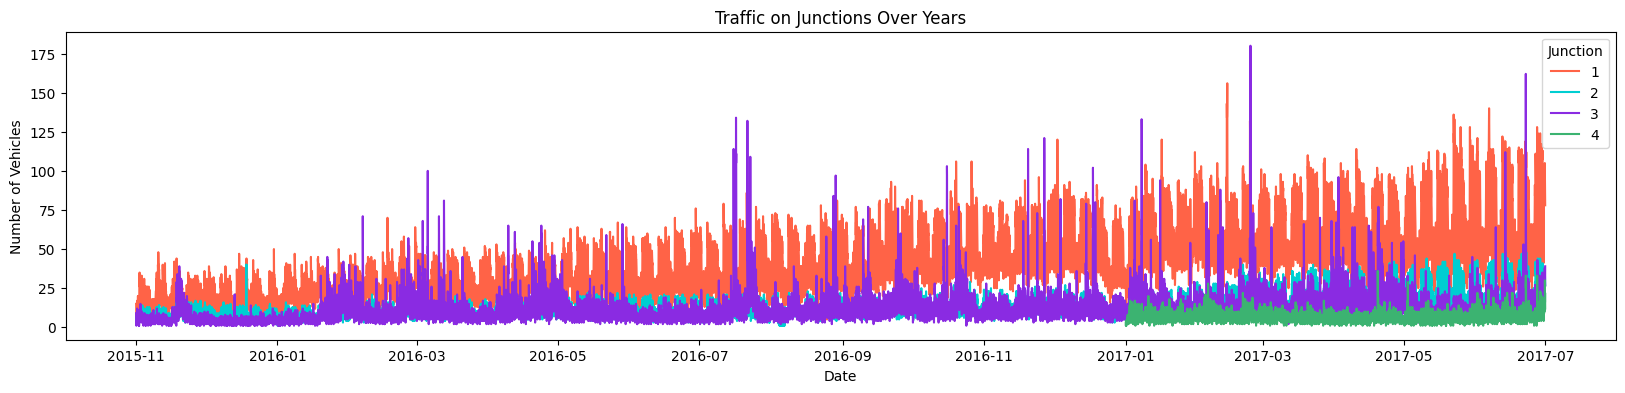

In [8]:

# Create a copy of the original dataframe for exploratory data analysis (EDA)
df = data.copy()

# Plotting the Time series
colors = ["#FF6347", "#00CED1", "#8A2BE2", "#3CB371"]
plt.figure(figsize=(20, 4))
Time_series = sns.lineplot(x=df['DateTime'], y="Vehicles", data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic on Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")
plt.show()



Key observations from the plot:

1. The first junction exhibits a clear upward trend over time.
2. Sparse data for the fourth junction is noticeable, with recordings beginning only after 2017.
3. Seasonality is not readily apparent from the plot, suggesting a need to explore the composition of datetime data to uncover further insights.

In [9]:
#Exploring more features
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


**EXPLORATORY DATA ANALYSIS**









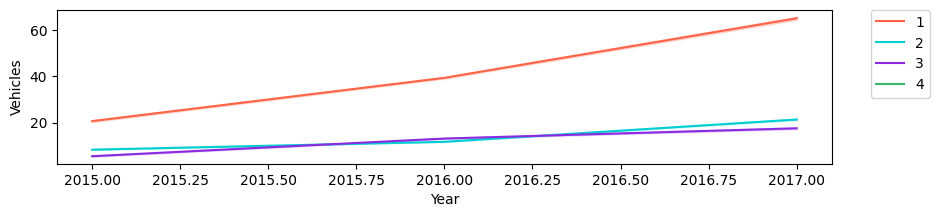

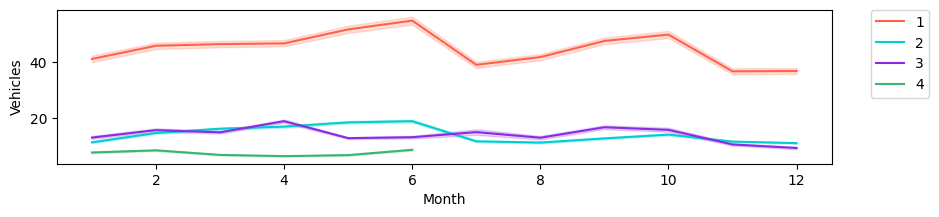

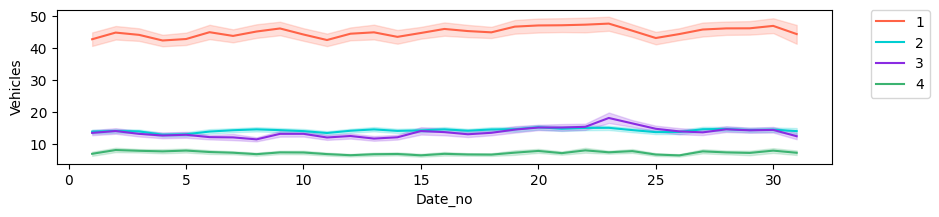

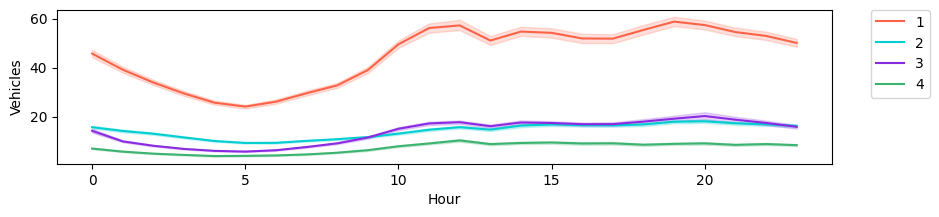

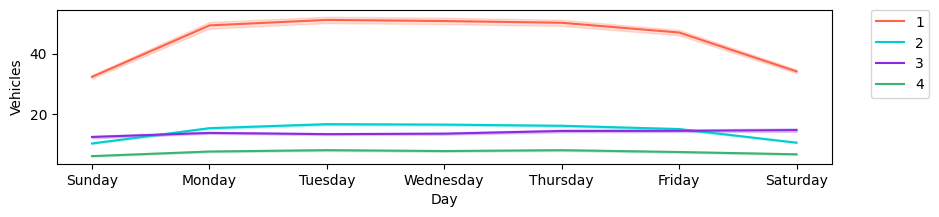

In [10]:
# Plotting the Time series for new features
new_features = ["Year", "Month", "Date_no", "Hour", "Day"]

for feature in new_features:
    plt.figure(figsize=(10, 2))
    ax = sns.lineplot(x=df[feature], y="Vehicles", data=df, hue="Junction", palette=colors)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Observations from the plots:

1. Yearly trends indicate an overall upward trajectory for all junctions, except the fourth junction, which lacks sufficient data spanning a full year.

2. Noticeable peaks in traffic occur around June in the first and second junctions, possibly attributed to summer break and related activities during that time.

3. Monthly patterns demonstrate consistent traffic levels across all dates throughout the year.

4. Daily trends show expected peaks during morning and evening rush hours, with a decline in traffic during nighttime hours.

5. Weekly patterns reveal smoother traffic flow on Sundays, with fewer vehicles on the roads compared to the weekdays (Monday to Friday), where traffic remains relatively steady.

Text(0.5, 0, 'Date')

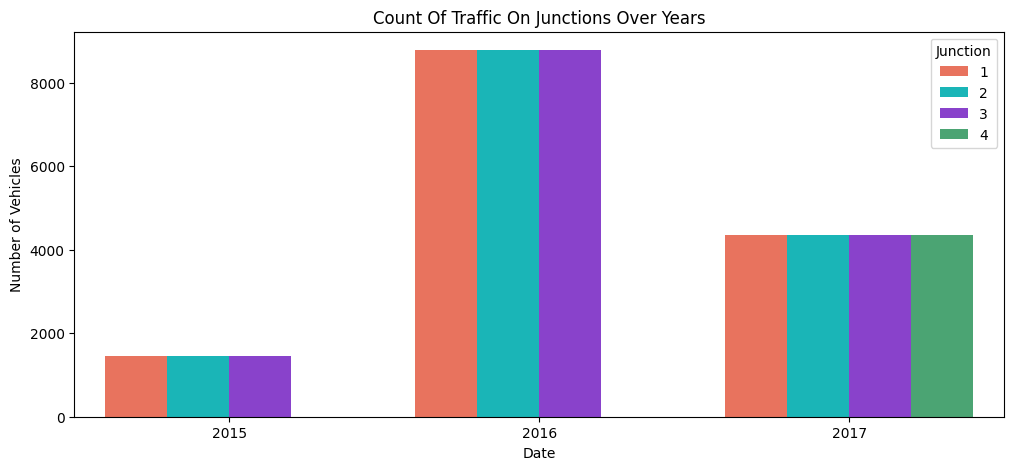

In [11]:
plt.figure(figsize=(12,5))
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

The count plot suggests an increase in the number of vehicles between 2015 and 2016. However, drawing conclusions about the trend for 2017 is inconclusive due to the limited data available for that year, extending only until the seventh month.

<Axes: >

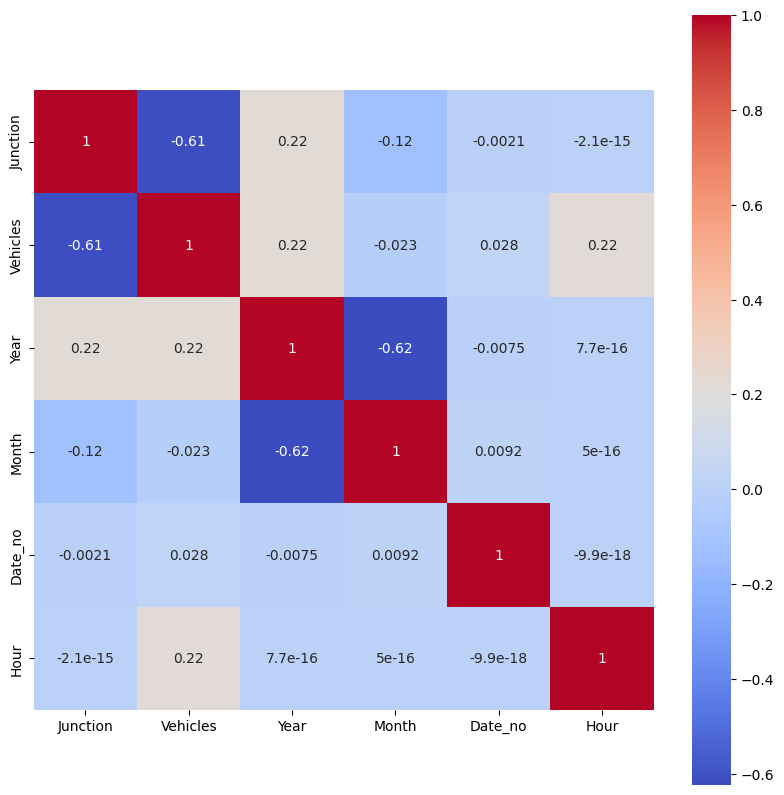

In [12]:
corrmat = df.corr()
plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, cmap="coolwarm", annot=True, square=True)


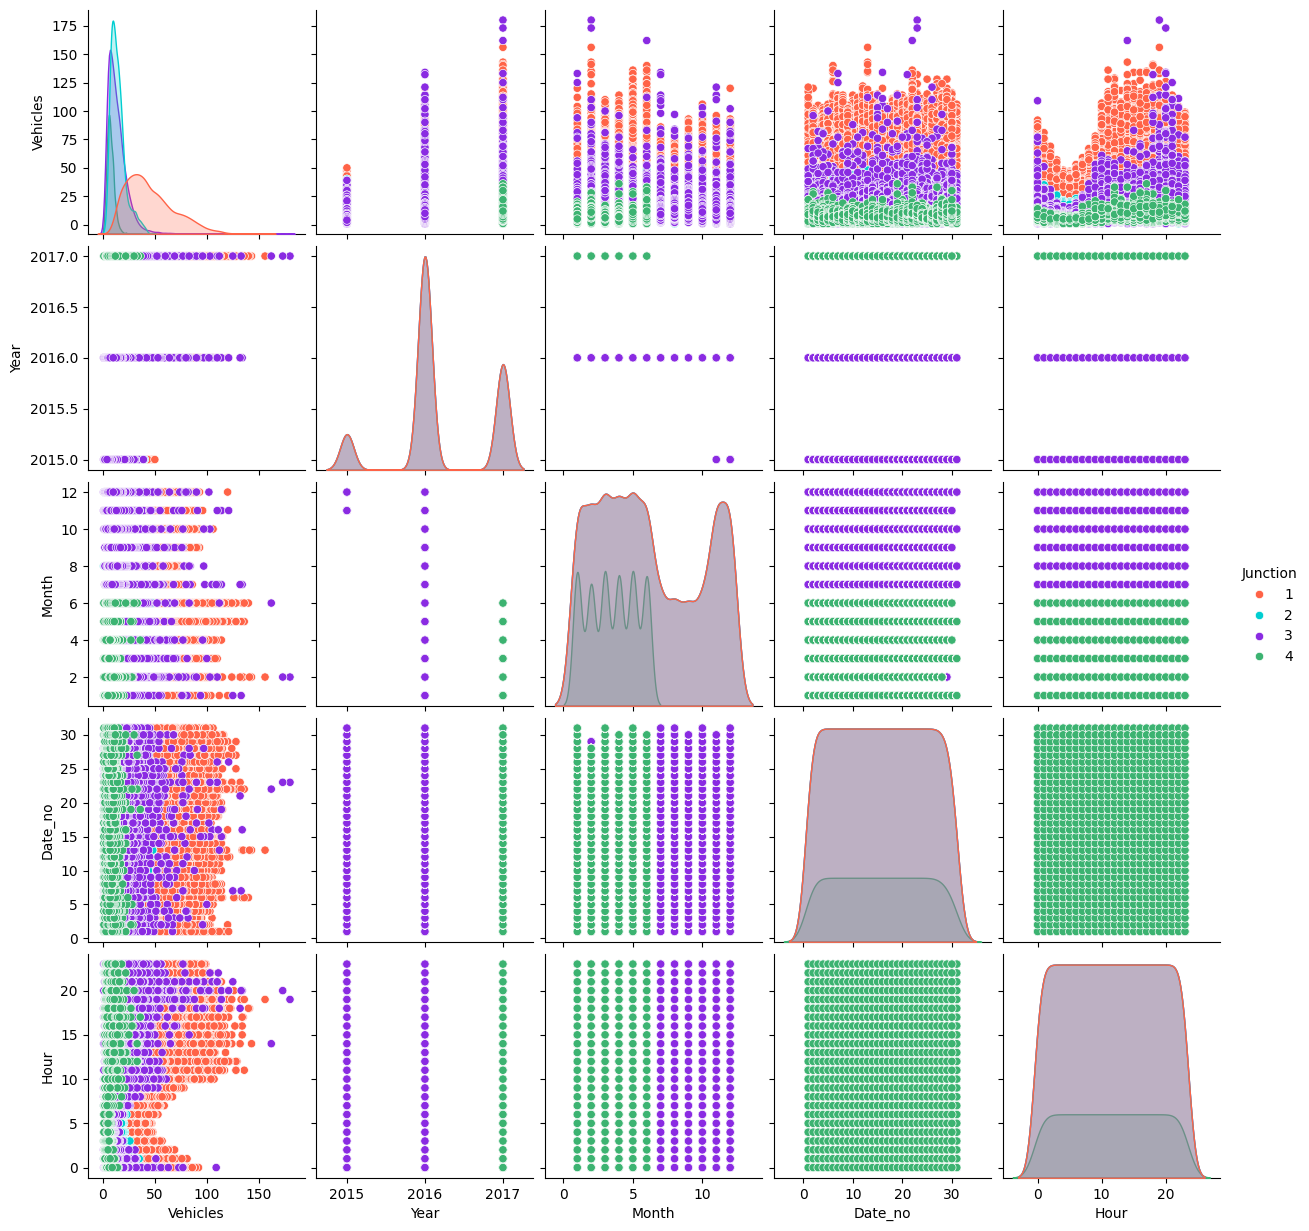

In [13]:
sns.pairplot(data=df, hue= "Junction",palette=colors)


Based on the exploratory data analysis (EDA) conducted, several conclusions can be drawn:

1. Discrepancies exist in the data coverage among the four junctions, with data for the fourth junction limited to the year 2017.
2. Yearly trends for junctions one, two, and three exhibit distinct slopes, suggesting varying traffic patterns among them.
3. Junction one displays a stronger weekly seasonality compared to the other junctions, indicating fluctuations in traffic volume throughout the week.
4. Given these observations, it's evident that each junction may require individualized transformation approaches to address their specific characteristics and optimize predictive modeling.

**DATA TRANSORMATION AND PREPROCESSING**

In [14]:
#Pivoting data fron junction
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

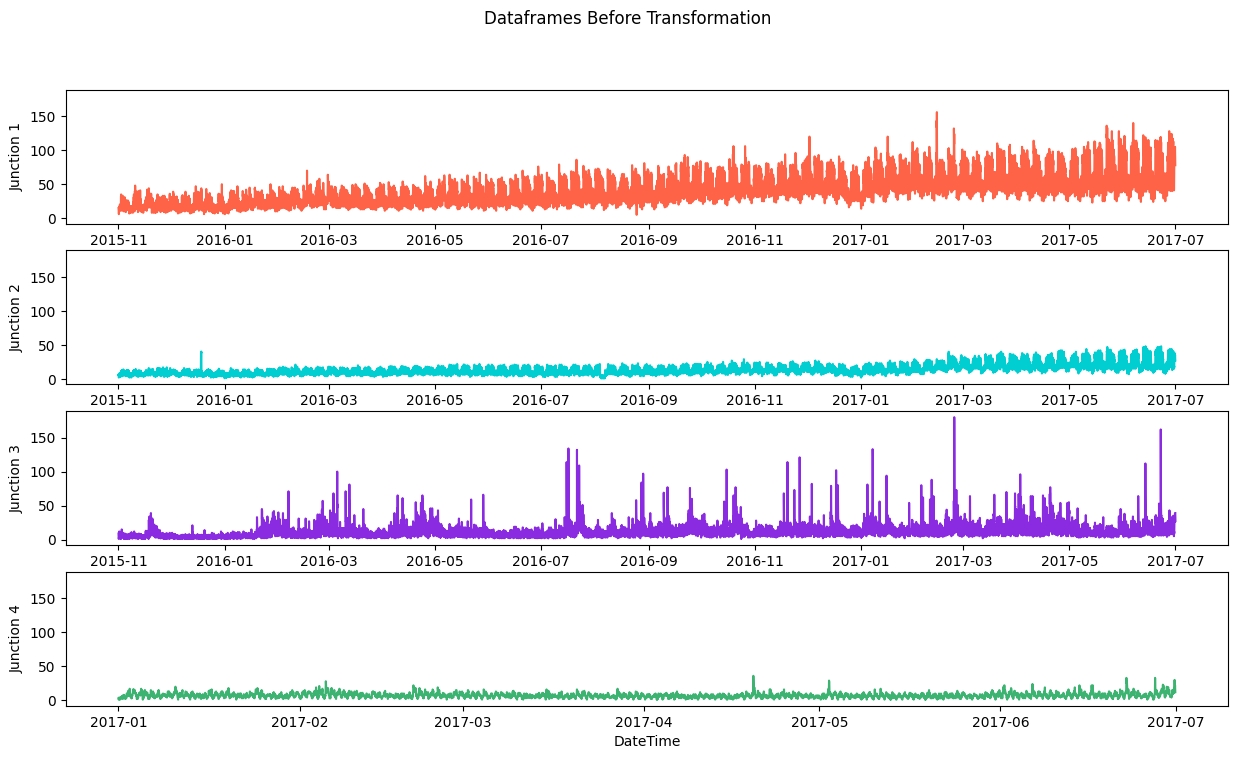

In [32]:
# Creating new datasets for each junction
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

Although a time series is considered stationary if it lacks trend or seasonality, our exploratory data analysis (EDA) revealed the presence of both weekly seasonality and upward trends over the years in the traffic data. Junctions one and two particularly exhibited noticeable upward trends. By limiting the time span, we could potentially reveal further insights into the weekly seasonality. However, at this stage, we'll proceed with the transformation steps for the datasets:

1. Normalizing: Scaling the values of the time series to a specific range, which helps remove scale effects and ensures consistency across the data.

2. Differencing: Computing the differences between consecutive observations in the time series to eliminate trends, thereby making the series stationary.

These transformation steps will prepare the datasets for further analysis and modeling.

In [16]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

Based on the observations :

1. For Junction one, differencing to eliminate weekly seasonality:
   - Take the difference of weekly values.

2. For Junction two, differencing to eliminate seasonality:
   - Choose the difference of consecutive days.

3. For Junctions three and four, differencing to eliminate seasonality:
   - Use the difference of hourly values.



In [17]:
#Normalizing and Differencing to make the series stationary
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

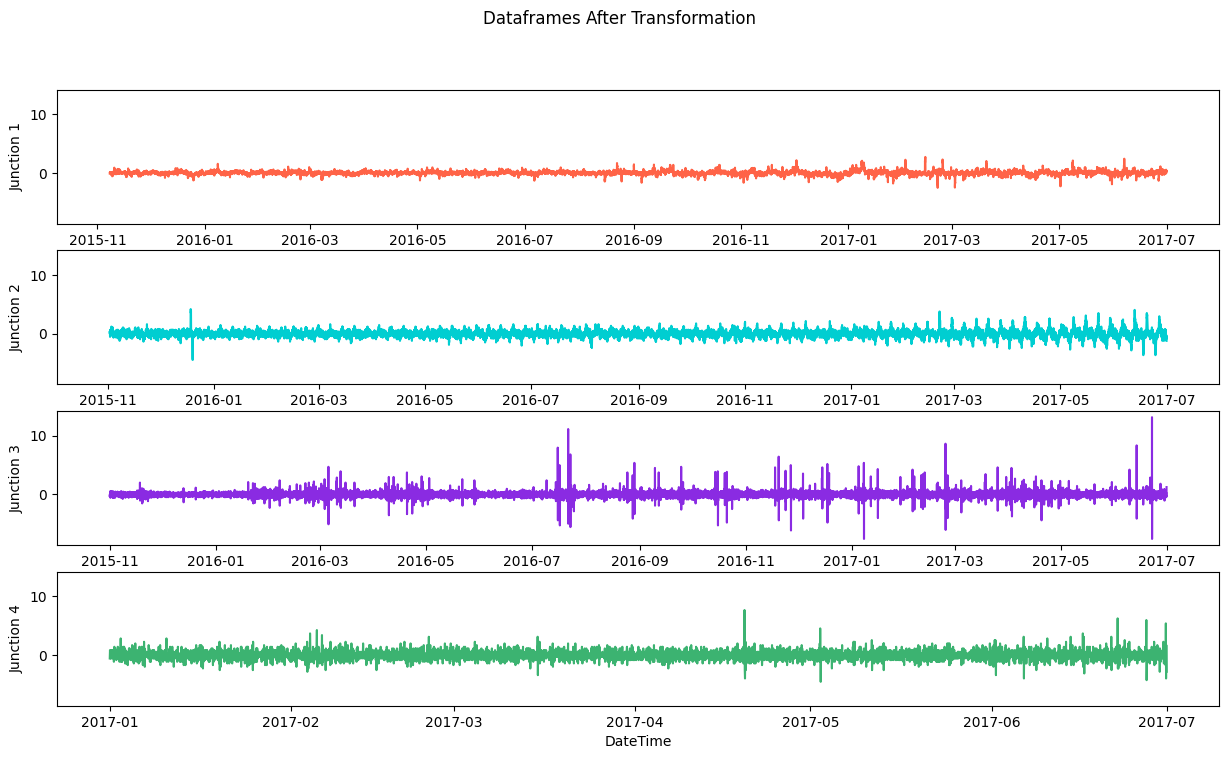

In [33]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

The plots shown above exhibit linear patterns. To verify their stationarity, I will conduct an Augmented Dickey-Fuller test.

In [19]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)


Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


Now that the data has been confirmed to be stationary, we'll proceed with preprocessing it for the neural network by:

1.Splitting the data into training and testing sets.

2.Assigning the features to variable X and the target variable to variable y.

3.Reshaping the data to meet the input requirements of the neural network.

In [20]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [34]:

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

Modelling and fitting the model

In [21]:
# Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
    # Callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!

    # The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='mean_squared_error')
    model.fit(X_Train, y_Train, epochs=50, batch_size=150, callbacks=[early_stopping])

    # Making predictions
    pred_GRU = model.predict(X_Test)
    return pred_GRU

# Predictions for all three junctions
pred_J1 = GRU_model(X_trainJ1, y_trainJ1 , X_testJ1,)
pred_J2 = GRU_model(X_trainJ2, y_trainJ2, X_testJ2)
pred_J3 = GRU_model(X_trainJ3, y_trainJ3, X_testJ3)
pred_J4 = GRU_model(X_trainJ4, y_trainJ4, X_testJ4)


Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.0730

87/87 [==============================] - 42s 361ms/step - loss: 0.0730
Epoch 2/50
87/87 [==============================] - ETA: 0s - loss: 0.0656

87/87 [==============================] - 39s 453ms/step - loss: 0.0656
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.0641

87/87 [==============================] - 32s 363ms/step - loss: 0.0641
Epoch 4/50
87/87 [==============================] - ETA: 0s - loss: 0.0625

87/87 [==============================] - 31s 360ms/step - loss: 0.0625
Epoch 5/50
87/87 [==============================] - ETA: 0s - loss: 0.0612

87/87 [==============================] - 34s 397ms/step - loss: 0.0612
Epoch 6/50
87/87 [==============================] - ETA: 0s - loss: 0.0603

87/87 [==============================] - 31s 362ms/step - loss: 0.0603
Epoch 7/50
87/87 [==============================] - ETA: 0s - loss: 0.0597

87/87 [==============================] - 31s 358ms/step - loss: 0.0597
Epoch 8/50
87/87 [==============================] - ETA: 0s - loss: 0.0579

87/87 [==============================] - 32s 364ms/step - loss: 0.0579
Epoch 9/50
87/87 [==============================] - ETA: 0s - loss: 0.0581

87/87 [==============================] - 32s 368ms/step - loss: 0.0581
Epoch 10/50
87/87 [==============================] - ETA: 0s - loss: 0.0574

87/87 [==============================] - 31s 360ms/step - loss: 0.0574
Epoch 11/50
87/87 [==============================] - ETA: 0s - loss: 0.0567

87/87 [==============================] - 35s 407ms/step - loss: 0.0567
Epoch 12/50
87/87 [==============================] - ETA: 0s - loss: 0.0551

87/87 [==============================] - 32s 369ms/step - loss: 0.0551
Epoch 13/50
87/87 [==============================] - ETA: 0s - loss: 0.0546

87/87 [==============================] - 31s 359ms/step - loss: 0.0546
Epoch 14/50
87/87 [==============================] - ETA: 0s - loss: 0.0548

87/87 [==============================] - 31s 360ms/step - loss: 0.0548
Epoch 15/50
87/87 [==============================] - ETA: 0s - loss: 0.0537

87/87 [==============================] - 34s 394ms/step - loss: 0.0537
Epoch 16/50
87/87 [==============================] - ETA: 0s - loss: 0.0537

87/87 [==============================] - 32s 367ms/step - loss: 0.0537
Epoch 17/50
87/87 [==============================] - ETA: 0s - loss: 0.0531

87/87 [==============================] - 32s 366ms/step - loss: 0.0531
Epoch 18/50
87/87 [==============================] - ETA: 0s - loss: 0.0526

87/87 [==============================] - 36s 409ms/step - loss: 0.0526
Epoch 19/50
87/87 [==============================] - ETA: 0s - loss: 0.0521

87/87 [==============================] - 33s 377ms/step - loss: 0.0521
Epoch 20/50
87/87 [==============================] - ETA: 0s - loss: 0.0529

87/87 [==============================] - 32s 363ms/step - loss: 0.0529
Epoch 21/50
87/87 [==============================] - ETA: 0s - loss: 0.0520

87/87 [==============================] - 33s 377ms/step - loss: 0.0520
Epoch 22/50
87/87 [==============================] - ETA: 0s - loss: 0.0516

87/87 [==============================] - 33s 379ms/step - loss: 0.0516
Epoch 23/50
87/87 [==============================] - ETA: 0s - loss: 0.0513

87/87 [==============================] - 32s 363ms/step - loss: 0.0513
Epoch 24/50
87/87 [==============================] - ETA: 0s - loss: 0.0508

87/87 [==============================] - 32s 368ms/step - loss: 0.0508
Epoch 25/50
87/87 [==============================] - ETA: 0s - loss: 0.0508

87/87 [==============================] - 31s 360ms/step - loss: 0.0508
Epoch 26/50
87/87 [==============================] - ETA: 0s - loss: 0.0506

87/87 [==============================] - 31s 359ms/step - loss: 0.0506
Epoch 27/50
87/87 [==============================] - ETA: 0s - loss: 0.0503

87/87 [==============================] - 33s 379ms/step - loss: 0.0503
Epoch 28/50
87/87 [==============================] - ETA: 0s - loss: 0.0504

87/87 [==============================] - 31s 356ms/step - loss: 0.0504
Epoch 29/50
87/87 [==============================] - ETA: 0s - loss: 0.0501

87/87 [==============================] - 31s 358ms/step - loss: 0.0501
Epoch 30/50
87/87 [==============================] - ETA: 0s - loss: 0.0503

87/87 [==============================] - 31s 359ms/step - loss: 0.0503
Epoch 31/50
87/87 [==============================] - ETA: 0s - loss: 0.0502

87/87 [==============================] - 32s 371ms/step - loss: 0.0502
Epoch 32/50
87/87 [==============================] - ETA: 0s - loss: 0.0497

87/87 [==============================] - 31s 357ms/step - loss: 0.0497
Epoch 33/50
87/87 [==============================] - ETA: 0s - loss: 0.0494

87/87 [==============================] - 33s 378ms/step - loss: 0.0494
Epoch 34/50
87/87 [==============================] - ETA: 0s - loss: 0.0494

87/87 [==============================] - 32s 367ms/step - loss: 0.0494
Epoch 35/50
87/87 [==============================] - ETA: 0s - loss: 0.0497

87/87 [==============================] - 32s 365ms/step - loss: 0.0497
Epoch 36/50
87/87 [==============================] - ETA: 0s - loss: 0.0492

87/87 [==============================] - 31s 358ms/step - loss: 0.0492
Epoch 37/50
87/87 [==============================] - ETA: 0s - loss: 0.0492

87/87 [==============================] - 31s 357ms/step - loss: 0.0492
Epoch 38/50
87/87 [==============================] - ETA: 0s - loss: 0.0491

87/87 [==============================] - 33s 377ms/step - loss: 0.0491
Epoch 39/50
87/87 [==============================] - ETA: 0s - loss: 0.0488

87/87 [==============================] - 31s 360ms/step - loss: 0.0488
Epoch 40/50
87/87 [==============================] - ETA: 0s - loss: 0.0488

87/87 [==============================] - 31s 357ms/step - loss: 0.0488
Epoch 41/50
87/87 [==============================] - ETA: 0s - loss: 0.0481

87/87 [==============================] - 31s 360ms/step - loss: 0.0481
Epoch 42/50
87/87 [==============================] - ETA: 0s - loss: 0.0483

87/87 [==============================] - 33s 372ms/step - loss: 0.0483
Epoch 43/50
87/87 [==============================] - ETA: 0s - loss: 0.0483

87/87 [==============================] - 31s 358ms/step - loss: 0.0483
Epoch 44/50
87/87 [==============================] - ETA: 0s - loss: 0.0483

87/87 [==============================] - 33s 376ms/step - loss: 0.0483
Epoch 45/50
87/87 [==============================] - ETA: 0s - loss: 0.0491

87/87 [==============================] - 33s 379ms/step - loss: 0.0491
Epoch 46/50
87/87 [==============================] - ETA: 0s - loss: 0.0476

87/87 [==============================] - 31s 359ms/step - loss: 0.0476
Epoch 47/50
87/87 [==============================] - ETA: 0s - loss: 0.0477

87/87 [==============================] - 31s 359ms/step - loss: 0.0477
Epoch 48/50
87/87 [==============================] - ETA: 0s - loss: 0.0486

87/87 [==============================] - 32s 374ms/step - loss: 0.0486
Epoch 49/50
87/87 [==============================] - ETA: 0s - loss: 0.0482

87/87 [==============================] - 32s 362ms/step - loss: 0.0482
Epoch 50/50
87/87 [==============================] - ETA: 0s - loss: 0.0475

45/45 [==============================] - 4s 43ms/step
Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.2325

88/88 [==============================] - 42s 361ms/step - loss: 0.2325
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.2044

88/88 [==============================] - 33s 375ms/step - loss: 0.2044
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.1979

88/88 [==============================] - 33s 371ms/step - loss: 0.1979
Epoch 4/50
88/88 [==============================] - ETA: 0s - loss: 0.1939

88/88 [==============================] - 34s 383ms/step - loss: 0.1939
Epoch 5/50
88/88 [==============================] - ETA: 0s - loss: 0.1931

88/88 [==============================] - 32s 367ms/step - loss: 0.1931
Epoch 6/50
88/88 [==============================] - ETA: 0s - loss: 0.1923

88/88 [==============================] - 33s 371ms/step - loss: 0.1923
Epoch 7/50
88/88 [==============================] - ETA: 0s - loss: 0.1916

88/88 [==============================] - 32s 363ms/step - loss: 0.1916
Epoch 8/50
88/88 [==============================] - ETA: 0s - loss: 0.1904

88/88 [==============================] - 32s 366ms/step - loss: 0.1904
Epoch 9/50
88/88 [==============================] - ETA: 0s - loss: 0.1901

88/88 [==============================] - 33s 372ms/step - loss: 0.1901
Epoch 10/50
88/88 [==============================] - ETA: 0s - loss: 0.1901

88/88 [==============================] - 32s 360ms/step - loss: 0.1901
Epoch 11/50
88/88 [==============================] - ETA: 0s - loss: 0.1893

88/88 [==============================] - 32s 362ms/step - loss: 0.1893
Epoch 12/50
88/88 [==============================] - ETA: 0s - loss: 0.1879

88/88 [==============================] - 33s 376ms/step - loss: 0.1879
Epoch 13/50
88/88 [==============================] - ETA: 0s - loss: 0.1878

88/88 [==============================] - 32s 359ms/step - loss: 0.1878
Epoch 14/50
88/88 [==============================] - ETA: 0s - loss: 0.1869

88/88 [==============================] - 31s 358ms/step - loss: 0.1869
Epoch 15/50
88/88 [==============================] - ETA: 0s - loss: 0.1871

88/88 [==============================] - 33s 377ms/step - loss: 0.1871
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.1857

88/88 [==============================] - 32s 361ms/step - loss: 0.1857
Epoch 17/50
88/88 [==============================] - ETA: 0s - loss: 0.1867

88/88 [==============================] - 32s 361ms/step - loss: 0.1867
Epoch 18/50
88/88 [==============================] - ETA: 0s - loss: 0.1859

88/88 [==============================] - 33s 378ms/step - loss: 0.1859
Epoch 19/50
88/88 [==============================] - ETA: 0s - loss: 0.1865

88/88 [==============================] - 32s 359ms/step - loss: 0.1865
Epoch 20/50
88/88 [==============================] - ETA: 0s - loss: 0.1856

88/88 [==============================] - 32s 364ms/step - loss: 0.1856
Epoch 21/50
88/88 [==============================] - ETA: 0s - loss: 0.1843

88/88 [==============================] - 33s 381ms/step - loss: 0.1843
Epoch 22/50
88/88 [==============================] - ETA: 0s - loss: 0.1846

88/88 [==============================] - 32s 360ms/step - loss: 0.1846
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.1857

88/88 [==============================] - 32s 361ms/step - loss: 0.1857
Epoch 24/50
88/88 [==============================] - ETA: 0s - loss: 0.1847

88/88 [==============================] - 33s 381ms/step - loss: 0.1847
Epoch 25/50
88/88 [==============================] - ETA: 0s - loss: 0.1842

88/88 [==============================] - 32s 361ms/step - loss: 0.1842
Epoch 26/50
88/88 [==============================] - ETA: 0s - loss: 0.1836

88/88 [==============================] - 32s 362ms/step - loss: 0.1836
Epoch 27/50
88/88 [==============================] - ETA: 0s - loss: 0.1846

88/88 [==============================] - 34s 382ms/step - loss: 0.1846
Epoch 28/50
88/88 [==============================] - ETA: 0s - loss: 0.1841

88/88 [==============================] - 32s 363ms/step - loss: 0.1841
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.1858

88/88 [==============================] - 32s 362ms/step - loss: 0.1858
Epoch 30/50
88/88 [==============================] - ETA: 0s - loss: 0.1846

88/88 [==============================] - 33s 381ms/step - loss: 0.1846
Epoch 31/50
88/88 [==============================] - ETA: 0s - loss: 0.1843

88/88 [==============================] - 32s 361ms/step - loss: 0.1843
Epoch 32/50
88/88 [==============================] - ETA: 0s - loss: 0.1832

88/88 [==============================] - 32s 360ms/step - loss: 0.1832
Epoch 33/50
88/88 [==============================] - ETA: 0s - loss: 0.1841

88/88 [==============================] - 33s 378ms/step - loss: 0.1841
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.1829

88/88 [==============================] - 32s 362ms/step - loss: 0.1829
Epoch 35/50
88/88 [==============================] - ETA: 0s - loss: 0.1835

88/88 [==============================] - 32s 360ms/step - loss: 0.1835
Epoch 36/50
88/88 [==============================] - ETA: 0s - loss: 0.1829

88/88 [==============================] - 33s 377ms/step - loss: 0.1829
Epoch 37/50
88/88 [==============================] - ETA: 0s - loss: 0.1836

88/88 [==============================] - 31s 356ms/step - loss: 0.1836
Epoch 38/50
88/88 [==============================] - ETA: 0s - loss: 0.1821

88/88 [==============================] - 31s 358ms/step - loss: 0.1821
Epoch 39/50
88/88 [==============================] - ETA: 0s - loss: 0.1826

88/88 [==============================] - 33s 378ms/step - loss: 0.1826
Epoch 40/50
88/88 [==============================] - ETA: 0s - loss: 0.1821

88/88 [==============================] - 32s 358ms/step - loss: 0.1821
Epoch 41/50
88/88 [==============================] - ETA: 0s - loss: 0.1813

88/88 [==============================] - 31s 357ms/step - loss: 0.1813
Epoch 42/50
88/88 [==============================] - ETA: 0s - loss: 0.1827

88/88 [==============================] - 32s 369ms/step - loss: 0.1827
Epoch 43/50
88/88 [==============================] - ETA: 0s - loss: 0.1805

88/88 [==============================] - 32s 363ms/step - loss: 0.1805
Epoch 44/50
88/88 [==============================] - ETA: 0s - loss: 0.1848

88/88 [==============================] - 31s 358ms/step - loss: 0.1848
Epoch 45/50
88/88 [==============================] - ETA: 0s - loss: 0.1814

88/88 [==============================] - 32s 368ms/step - loss: 0.1814
Epoch 46/50
88/88 [==============================] - ETA: 0s - loss: 0.1819

88/88 [==============================] - 32s 366ms/step - loss: 0.1819
Epoch 47/50
88/88 [==============================] - ETA: 0s - loss: 0.1817

88/88 [==============================] - 32s 359ms/step - loss: 0.1817
Epoch 48/50
88/88 [==============================] - ETA: 0s - loss: 0.1808

88/88 [==============================] - 32s 362ms/step - loss: 0.1808
Epoch 49/50
88/88 [==============================] - ETA: 0s - loss: 0.1821

88/88 [==============================] - 33s 373ms/step - loss: 0.1821
Epoch 50/50
88/88 [==============================] - ETA: 0s - loss: 0.1807

45/45 [==============================] - 5s 51ms/step
Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.3015

88/88 [==============================] - 40s 355ms/step - loss: 0.3015
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.2939

88/88 [==============================] - 31s 358ms/step - loss: 0.2939
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.2917

88/88 [==============================] - 33s 373ms/step - loss: 0.2917
Epoch 4/50
88/88 [==============================] - ETA: 0s - loss: 0.2909

88/88 [==============================] - 32s 357ms/step - loss: 0.2909
Epoch 5/50
88/88 [==============================] - ETA: 0s - loss: 0.2890

88/88 [==============================] - 32s 359ms/step - loss: 0.2890
Epoch 6/50
88/88 [==============================] - ETA: 0s - loss: 0.2878

88/88 [==============================] - 32s 363ms/step - loss: 0.2878
Epoch 7/50
88/88 [==============================] - ETA: 0s - loss: 0.2871

88/88 [==============================] - 33s 368ms/step - loss: 0.2871
Epoch 8/50
88/88 [==============================] - ETA: 0s - loss: 0.2878

88/88 [==============================] - 31s 355ms/step - loss: 0.2878
Epoch 9/50
88/88 [==============================] - ETA: 0s - loss: 0.2892

88/88 [==============================] - 31s 355ms/step - loss: 0.2892
Epoch 10/50
88/88 [==============================] - ETA: 0s - loss: 0.2881

88/88 [==============================] - 33s 376ms/step - loss: 0.2881
Epoch 11/50
88/88 [==============================] - ETA: 0s - loss: 0.2842

88/88 [==============================] - 31s 357ms/step - loss: 0.2842
Epoch 12/50
88/88 [==============================] - ETA: 0s - loss: 0.2851

88/88 [==============================] - 31s 357ms/step - loss: 0.2851
Epoch 13/50
88/88 [==============================] - ETA: 0s - loss: 0.2849

88/88 [==============================] - 33s 373ms/step - loss: 0.2849
Epoch 14/50
88/88 [==============================] - ETA: 0s - loss: 0.2840

88/88 [==============================] - 32s 359ms/step - loss: 0.2840
Epoch 15/50
88/88 [==============================] - ETA: 0s - loss: 0.2815

88/88 [==============================] - 31s 355ms/step - loss: 0.2815
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.2804

88/88 [==============================] - 32s 359ms/step - loss: 0.2804
Epoch 17/50
88/88 [==============================] - ETA: 0s - loss: 0.2802

88/88 [==============================] - 33s 370ms/step - loss: 0.2802
Epoch 18/50
88/88 [==============================] - ETA: 0s - loss: 0.2781

88/88 [==============================] - 31s 357ms/step - loss: 0.2781
Epoch 19/50
88/88 [==============================] - ETA: 0s - loss: 0.2785

88/88 [==============================] - 31s 356ms/step - loss: 0.2785
Epoch 20/50
88/88 [==============================] - ETA: 0s - loss: 0.2769

88/88 [==============================] - 33s 377ms/step - loss: 0.2769
Epoch 21/50
88/88 [==============================] - ETA: 0s - loss: 0.2736

88/88 [==============================] - 31s 355ms/step - loss: 0.2736
Epoch 22/50
88/88 [==============================] - ETA: 0s - loss: 0.2750

88/88 [==============================] - 31s 356ms/step - loss: 0.2750
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.2734

88/88 [==============================] - 33s 380ms/step - loss: 0.2734
Epoch 24/50
88/88 [==============================] - ETA: 0s - loss: 0.2756

88/88 [==============================] - 32s 360ms/step - loss: 0.2756
Epoch 25/50
88/88 [==============================] - ETA: 0s - loss: 0.2729

88/88 [==============================] - 31s 356ms/step - loss: 0.2729
Epoch 26/50
88/88 [==============================] - ETA: 0s - loss: 0.2791

88/88 [==============================] - 32s 365ms/step - loss: 0.2791
Epoch 27/50
88/88 [==============================] - ETA: 0s - loss: 0.2750

88/88 [==============================] - 32s 363ms/step - loss: 0.2750
Epoch 28/50
88/88 [==============================] - ETA: 0s - loss: 0.2765

88/88 [==============================] - 32s 360ms/step - loss: 0.2765
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.2695

88/88 [==============================] - 32s 362ms/step - loss: 0.2695
Epoch 30/50
88/88 [==============================] - ETA: 0s - loss: 0.2689

88/88 [==============================] - 32s 367ms/step - loss: 0.2689
Epoch 31/50
88/88 [==============================] - ETA: 0s - loss: 0.2723

88/88 [==============================] - 31s 352ms/step - loss: 0.2723
Epoch 32/50
88/88 [==============================] - ETA: 0s - loss: 0.2727

88/88 [==============================] - 31s 349ms/step - loss: 0.2727
Epoch 33/50
88/88 [==============================] - ETA: 0s - loss: 0.2697

88/88 [==============================] - 33s 370ms/step - loss: 0.2697
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.2706

88/88 [==============================] - 31s 350ms/step - loss: 0.2706
Epoch 35/50
88/88 [==============================] - ETA: 0s - loss: 0.2703

88/88 [==============================] - 31s 348ms/step - loss: 0.2703
Epoch 36/50
88/88 [==============================] - ETA: 0s - loss: 0.2690

88/88 [==============================] - 30s 346ms/step - loss: 0.2690
Epoch 37/50
88/88 [==============================] - ETA: 0s - loss: 0.2724

88/88 [==============================] - 32s 365ms/step - loss: 0.2724
Epoch 38/50
88/88 [==============================] - ETA: 0s - loss: 0.2686

88/88 [==============================] - 31s 353ms/step - loss: 0.2686
Epoch 39/50
88/88 [==============================] - ETA: 0s - loss: 0.2681

88/88 [==============================] - 31s 355ms/step - loss: 0.2681
Epoch 40/50
88/88 [==============================] - ETA: 0s - loss: 0.2683

88/88 [==============================] - 32s 362ms/step - loss: 0.2683
Epoch 41/50
88/88 [==============================] - ETA: 0s - loss: 0.2646

88/88 [==============================] - 32s 358ms/step - loss: 0.2646
Epoch 42/50
88/88 [==============================] - ETA: 0s - loss: 0.2658

88/88 [==============================] - 31s 355ms/step - loss: 0.2658
Epoch 43/50
88/88 [==============================] - ETA: 0s - loss: 0.2653

88/88 [==============================] - 31s 354ms/step - loss: 0.2653
Epoch 44/50
88/88 [==============================] - ETA: 0s - loss: 0.2674

88/88 [==============================] - 32s 369ms/step - loss: 0.2674
Epoch 45/50
88/88 [==============================] - ETA: 0s - loss: 0.2681

88/88 [==============================] - 31s 348ms/step - loss: 0.2681
Epoch 46/50
88/88 [==============================] - ETA: 0s - loss: 0.2643

88/88 [==============================] - 31s 349ms/step - loss: 0.2643
Epoch 47/50
88/88 [==============================] - ETA: 0s - loss: 0.2657

88/88 [==============================] - 31s 355ms/step - loss: 0.2657
Epoch 48/50
88/88 [==============================] - ETA: 0s - loss: 0.2638

88/88 [==============================] - 32s 365ms/step - loss: 0.2638
Epoch 49/50
88/88 [==============================] - ETA: 0s - loss: 0.2628

88/88 [==============================] - 31s 355ms/step - loss: 0.2628
Epoch 50/50
88/88 [==============================] - ETA: 0s - loss: 0.2640

45/45 [==============================] - 6s 81ms/step
Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.6912

26/26 [==============================] - 18s 368ms/step - loss: 0.6912
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.6903

26/26 [==============================] - 10s 378ms/step - loss: 0.6903
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.6906

26/26 [==============================] - 8s 323ms/step - loss: 0.6906
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.6870

26/26 [==============================] - 9s 354ms/step - loss: 0.6870
Epoch 5/50
26/26 [==============================] - ETA: 0s - loss: 0.6872

26/26 [==============================] - 10s 371ms/step - loss: 0.6872
Epoch 6/50
26/26 [==============================] - ETA: 0s - loss: 0.6947

26/26 [==============================] - 8s 322ms/step - loss: 0.6947
Epoch 7/50
26/26 [==============================] - ETA: 0s - loss: 0.6843

26/26 [==============================] - 9s 349ms/step - loss: 0.6843
Epoch 8/50
26/26 [==============================] - ETA: 0s - loss: 0.6830

26/26 [==============================] - 10s 372ms/step - loss: 0.6830
Epoch 9/50
26/26 [==============================] - ETA: 0s - loss: 0.6812

26/26 [==============================] - 9s 331ms/step - loss: 0.6812
Epoch 10/50
26/26 [==============================] - ETA: 0s - loss: 0.6792

26/26 [==============================] - 9s 348ms/step - loss: 0.6792
Epoch 11/50
26/26 [==============================] - ETA: 0s - loss: 0.6790

26/26 [==============================] - 10s 372ms/step - loss: 0.6790
Epoch 12/50
26/26 [==============================] - ETA: 0s - loss: 0.6790

26/26 [==============================] - 8s 322ms/step - loss: 0.6790
Epoch 13/50
26/26 [==============================] - ETA: 0s - loss: 0.6782

26/26 [==============================] - 9s 352ms/step - loss: 0.6782
Epoch 14/50
26/26 [==============================] - ETA: 0s - loss: 0.6783

26/26 [==============================] - 10s 371ms/step - loss: 0.6783
Epoch 15/50
26/26 [==============================] - ETA: 0s - loss: 0.6801

26/26 [==============================] - 8s 325ms/step - loss: 0.6801
Epoch 16/50
26/26 [==============================] - ETA: 0s - loss: 0.6794

26/26 [==============================] - 9s 349ms/step - loss: 0.6794
Epoch 17/50
26/26 [==============================] - ETA: 0s - loss: 0.6767

26/26 [==============================] - 10s 368ms/step - loss: 0.6767
Epoch 18/50
26/26 [==============================] - ETA: 0s - loss: 0.6738

26/26 [==============================] - 8s 314ms/step - loss: 0.6738
Epoch 19/50
26/26 [==============================] - ETA: 0s - loss: 0.6805

26/26 [==============================] - 9s 353ms/step - loss: 0.6805
Epoch 20/50
26/26 [==============================] - ETA: 0s - loss: 0.6799

26/26 [==============================] - 10s 369ms/step - loss: 0.6799
Epoch 21/50
26/26 [==============================] - ETA: 0s - loss: 0.6817

26/26 [==============================] - 8s 310ms/step - loss: 0.6817
Epoch 22/50
26/26 [==============================] - ETA: 0s - loss: 0.6840

26/26 [==============================] - 10s 358ms/step - loss: 0.6840
Epoch 23/50
26/26 [==============================] - ETA: 0s - loss: 0.6760

26/26 [==============================] - 9s 368ms/step - loss: 0.6760
Epoch 24/50
26/26 [==============================] - ETA: 0s - loss: 0.6732

26/26 [==============================] - 8s 312ms/step - loss: 0.6732
Epoch 25/50
26/26 [==============================] - ETA: 0s - loss: 0.6708

26/26 [==============================] - 10s 368ms/step - loss: 0.6708
Epoch 26/50
26/26 [==============================] - ETA: 0s - loss: 0.6733

26/26 [==============================] - 10s 374ms/step - loss: 0.6733
Epoch 27/50
26/26 [==============================] - ETA: 0s - loss: 0.6707

26/26 [==============================] - 8s 303ms/step - loss: 0.6707
Epoch 28/50
26/26 [==============================] - ETA: 0s - loss: 0.6740

26/26 [==============================] - 10s 365ms/step - loss: 0.6740
Epoch 29/50
26/26 [==============================] - ETA: 0s - loss: 0.6693

26/26 [==============================] - 10s 371ms/step - loss: 0.6693
Epoch 30/50
26/26 [==============================] - ETA: 0s - loss: 0.6662

26/26 [==============================] - 8s 308ms/step - loss: 0.6662
Epoch 31/50
26/26 [==============================] - ETA: 0s - loss: 0.6657

26/26 [==============================] - 10s 368ms/step - loss: 0.6657
Epoch 32/50
26/26 [==============================] - ETA: 0s - loss: 0.6705

26/26 [==============================] - 10s 370ms/step - loss: 0.6705
Epoch 33/50
26/26 [==============================] - ETA: 0s - loss: 0.6751

26/26 [==============================] - 8s 305ms/step - loss: 0.6751
Epoch 34/50
26/26 [==============================] - ETA: 0s - loss: 0.6647

26/26 [==============================] - 10s 369ms/step - loss: 0.6647
Epoch 35/50
26/26 [==============================] - ETA: 0s - loss: 0.6586

26/26 [==============================] - 10s 372ms/step - loss: 0.6586
Epoch 36/50
26/26 [==============================] - ETA: 0s - loss: 0.6533

26/26 [==============================] - 8s 310ms/step - loss: 0.6533
Epoch 37/50
26/26 [==============================] - ETA: 0s - loss: 0.6508

26/26 [==============================] - 10s 372ms/step - loss: 0.6508
Epoch 38/50
26/26 [==============================] - ETA: 0s - loss: 0.6475

26/26 [==============================] - 10s 368ms/step - loss: 0.6475
Epoch 39/50
26/26 [==============================] - ETA: 0s - loss: 0.6407

26/26 [==============================] - 8s 306ms/step - loss: 0.6407
Epoch 40/50
26/26 [==============================] - ETA: 0s - loss: 0.6522

26/26 [==============================] - 10s 370ms/step - loss: 0.6522
Epoch 41/50
26/26 [==============================] - ETA: 0s - loss: 0.6342

26/26 [==============================] - 10s 370ms/step - loss: 0.6342
Epoch 42/50
26/26 [==============================] - ETA: 0s - loss: 0.6308

26/26 [==============================] - 8s 310ms/step - loss: 0.6308
Epoch 43/50
26/26 [==============================] - ETA: 0s - loss: 0.6190

26/26 [==============================] - 10s 375ms/step - loss: 0.6190
Epoch 44/50
26/26 [==============================] - ETA: 0s - loss: 0.6196

26/26 [==============================] - 10s 375ms/step - loss: 0.6196
Epoch 45/50
26/26 [==============================] - ETA: 0s - loss: 0.6030

26/26 [==============================] - 8s 323ms/step - loss: 0.6030
Epoch 46/50
26/26 [==============================] - ETA: 0s - loss: 0.5936

26/26 [==============================] - 10s 382ms/step - loss: 0.5936
Epoch 47/50
26/26 [==============================] - ETA: 0s - loss: 0.5953

26/26 [==============================] - 10s 380ms/step - loss: 0.5953
Epoch 48/50
26/26 [==============================] - ETA: 0s - loss: 0.5919

26/26 [==============================] - 8s 318ms/step - loss: 0.5919
Epoch 49/50
26/26 [==============================] - ETA: 0s - loss: 0.5766

26/26 [==============================] - 10s 374ms/step - loss: 0.5766
Epoch 50/50
26/26 [==============================] - ETA: 0s - loss: 0.5648

13/13 [==============================] - 3s 63ms/step


Model Construction:

In this project, I've opted to utilize Gated Recurrent Unit (GRU) for modeling. Within this segment, I'm developing a function that the neural network can invoke to train on and fit the datasets for all four junctions.

The root mean squared error is 0.24639023234784216.


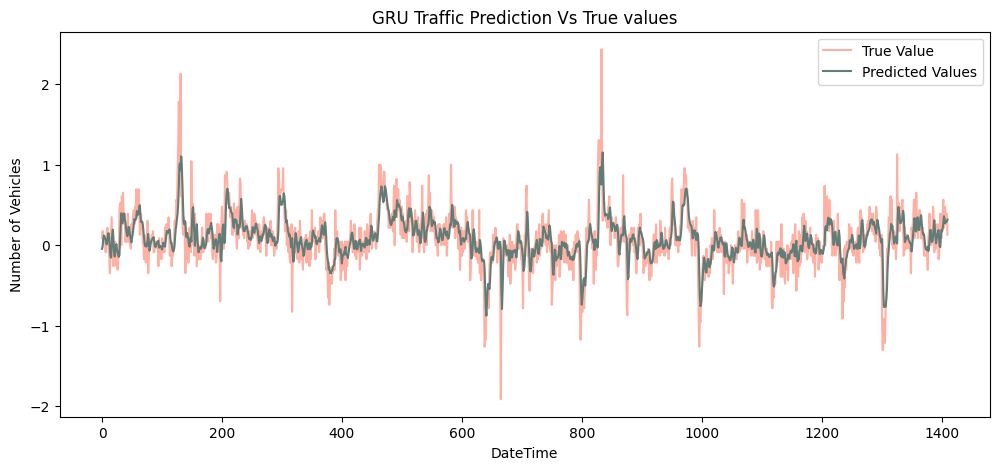

In [35]:
#Results for J1
RMSE_J1=RMSE_Value(y_testJ1,pred_J1)
PredictionsPlot(y_testJ1,pred_J1,0)

The root mean squared error is 0.5641650961158028.


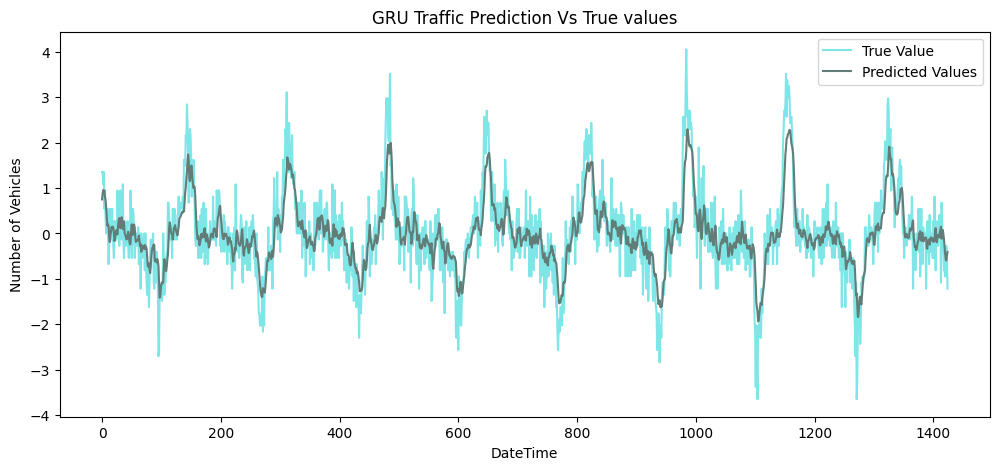

In [36]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,pred_J2)
PredictionsPlot(y_testJ2,pred_J2,1)

The root mean squared error is 0.6078655345413903.


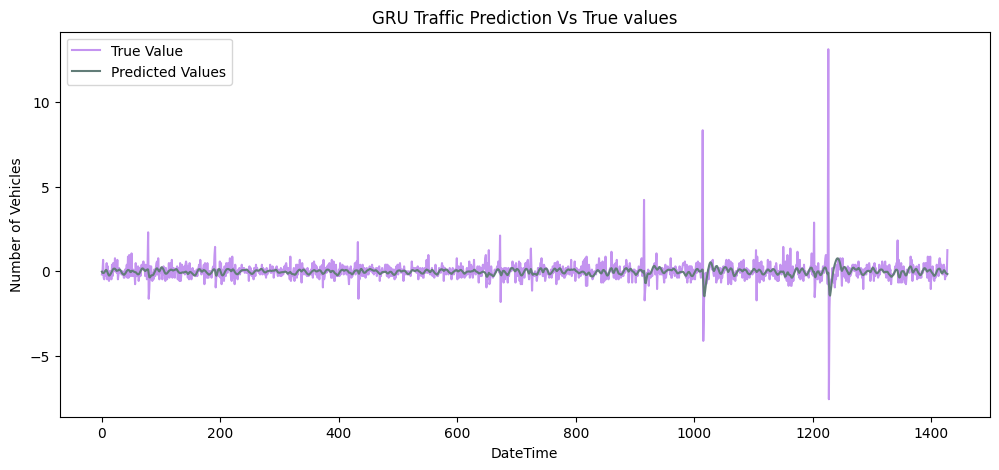

In [41]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,pred_J3)
PredictionsPlot(y_testJ3,pred_J3,2)


The root mean squared error is 1.0139746897184747.


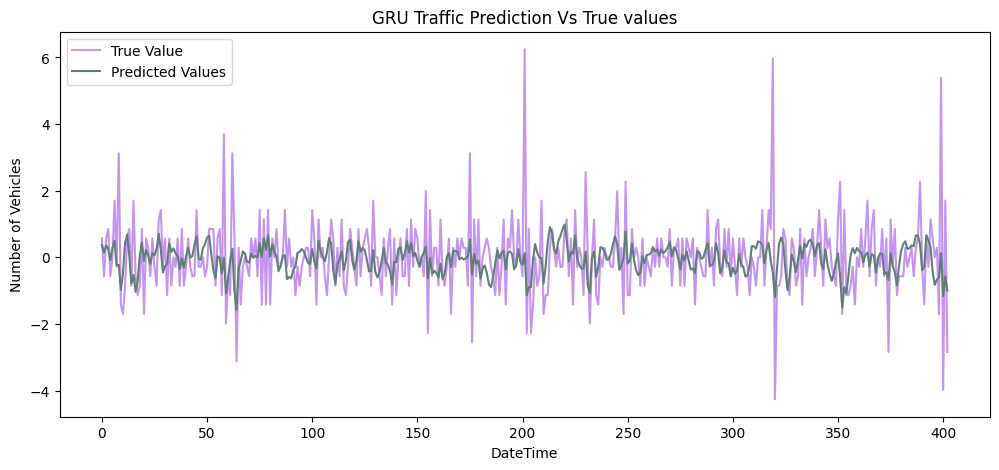

In [42]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,pred_J4)
PredictionsPlot(y_testJ4,pred_J4,2)

In [43]:
rmse_df = pd.DataFrame({
    "J Series": ["J1", "J2", "J3", "J4"],
    "RMSE Value": [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]
})

# Display the DataFrame
print(rmse_df)

  J Series  RMSE Value
0       J1    0.246390
1       J2    0.564165
2       J3    0.607866
3       J4    1.013975


In this phase, I'll be reverting the transformations applied to the datasets to eliminate seasonality and trends. Executing this step will ensure that the predictions return to their original scale, enhancing their accuracy.

In [44]:
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed

# Plotting the comparison
def Sub_Plots2(df_1, df_2, title, m):
    fig, axes = plt.subplots(1, 2, figsize=(18, 4), sharey=True)
    fig.suptitle(title)

    pl_1 = sns.lineplot(ax=axes[0], data=df_1, color=colors[m])
    axes[0].set_ylabel("Prediction")

    pl_2 = sns.lineplot(ax=axes[1], data=df_2["Vehicles"], color="#627D78")
    axes[1].set_ylabel("Original")


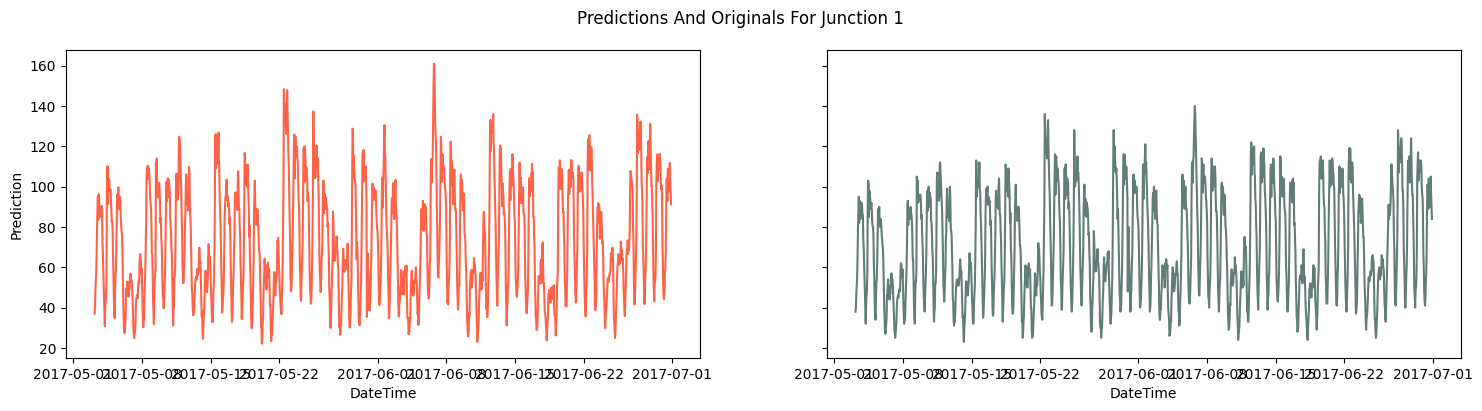

In [46]:
# Invert the differenced forecast for Junction 1
recovered_df_J1 = df_N1.Norm[-1412:-1].to_frame()
recovered_df_J1["Pred"] = pred_J1
inverted_df_J1 = inverse_difference(recovered_df_J1.Norm, recovered_df_J1.Pred).to_frame()
inverted_df_J1.columns = ["Pred_Normed"]

# Invert the normalization for Junction 1
final_pred_J1 = (inverted_df_J1.values * std_J1) + av_J1
inverted_df_J1["Pred_Final"] = final_pred_J1

# Plotting the predictions with originals for Junction 1
Sub_Plots2(inverted_df_J1["Pred_Final"], df_1[-1412:-1], "Predictions And Originals For Junction 1", 0)


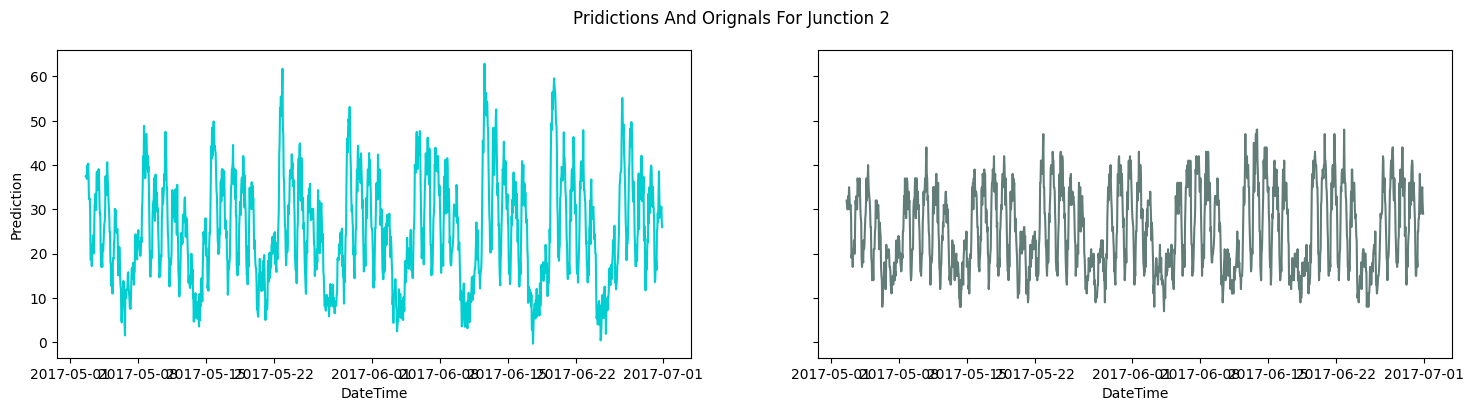

In [48]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= pred_J2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

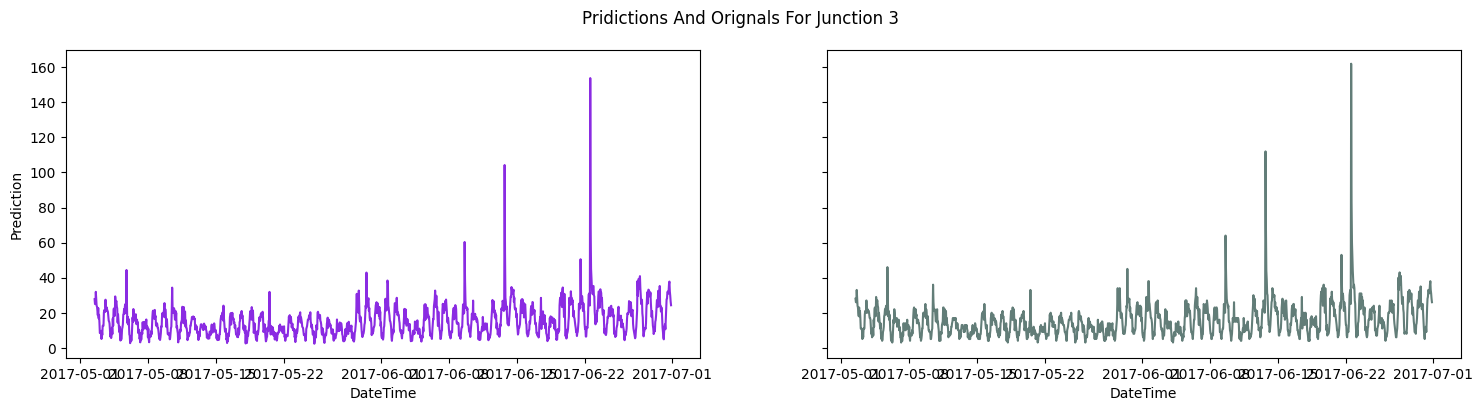

In [49]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= pred_J3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

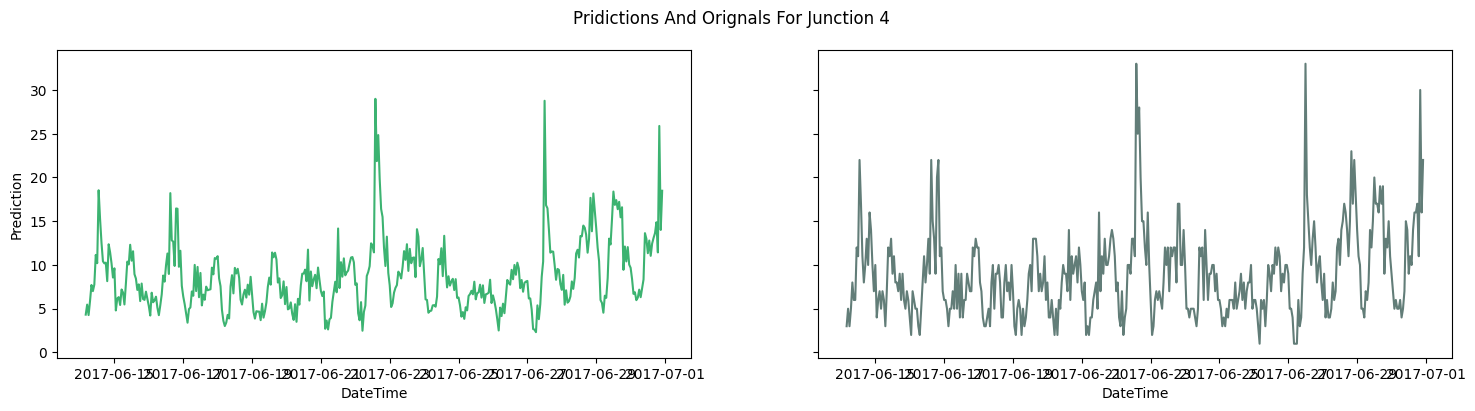

In [50]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= pred_J4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)

Summary:

In this project, I developed a GRU Neural Network model to forecast traffic levels at four junctions. To prepare the data for modeling, I applied normalization and differencing transformations to achieve stationary time series. Given that each junction exhibits different trends and seasonality patterns, I tailored the transformation approach accordingly for each junction.

Evaluation of the model performance was based on the root mean squared error (RMSE), providing insight into the accuracy of the predictions. Additionally, I visualized the predicted values alongside the original test data to assess the model's performance visually.

Key findings from the data analysis include:
- Junction one experiences a more rapid increase in traffic compared to junctions two and three.
- The data for junction four is sparse, limiting conclusive analysis.
- Junction one exhibits strong weekly and hourly seasonality, while other junctions show more linear patterns.

These insights enhance our understanding of traffic patterns at different junctions and can inform decision-making for transportation planning and management.